<a href="https://colab.research.google.com/github/namanphy/Controllable-Image-Captioning-App/blob/master/S5/eva_session5%20-%20iter%204.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Iteration 4





Target
1. Add BatchNormalisation to increase the model efficiency.
2. Added more capacity at the end. Just before the 1x1 layer.
3. Reduced the batch size - To help the model escape any local minima.

Results
1. parameters = 6,398
2. Best Train Accuracy = 99.58
3. Best Test Accuracy = 99.25

Analysis
1. Increased training accuracy after using Batch Normalisation - and it is well above target.
2. Overfitting - The model is still overfitting - After 7th epoch it started shoowing signs of overfitting.
3. The model is becomming good and can be better if pushed further. But it is not robust as the test accuracy keeps on fluctuating.



---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
from torchsummary import summary

## Getting to know our data

In [2]:
# Downloading the dataset and setting up dataloader for visualisationn only

train_set = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)

torch.Size([64, 1, 28, 28])
torch.Size([64])




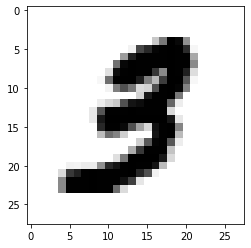

In [3]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_set.train_data
train_data = train_set.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_set.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_set.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

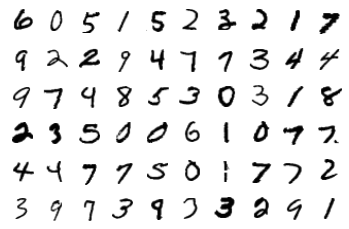

In [4]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Setting up Dataloaders and Transformations


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [24]:
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

train_set = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_set = datasets.MNIST('../data', train=False, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_set , batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)


## Making our model

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, bias=False), # RF - 3x3
            nn.BatchNorm2d(10),
            nn.ReLU(), # RF - 3x3
            
            nn.Conv2d(10, 10, 3, bias=False), # RF - 5x5
            nn.BatchNorm2d(10),
            nn.ReLU(), # RF - 5x5

            nn.MaxPool2d(2, 2), # RF - 10x10
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, bias=False), # RF - 12x12
            nn.BatchNorm2d(16),
            nn.ReLU(), # RF - 12x12

            nn.Conv2d(16, 16, 3, bias=False), # RF - 14x14
            nn.BatchNorm2d(16),
            nn.ReLU(), # RF - 14x14

            nn.MaxPool2d(2, 2), # RF - 28x28
            
            nn.Conv2d(16, 10, 3, bias=False), # RF - 30x30
            nn.BatchNorm2d(10),
            nn.ReLU(), # RF - 30x30

        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(10, 10, 1, bias=False) # RF - 30x30
            nn.BatchNorm2d(10),
            nn.ReLU(), # RF - 30x30
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.mean(dim=[-2,-1]) # GAP Layer
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [33]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
         MaxPool2d-7           [-1, 10, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,440
       BatchNorm2d-9           [-1, 16, 10, 10]              32
             ReLU-10           [-1, 16, 10, 10]               0
           Conv2d-11             [-1, 16, 8, 8]           2,304
      BatchNorm2d-12             [-1, 16, 8, 8]              32
             ReLU-13             [-1, 16, 8, 8]               0
        MaxPool2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [34]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    print(f"EPOCH - {epoch}")
    model.train()
    pbar = tqdm(train_loader, position=0, leave=True)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [35]:
data, target = next(iter(train_loader))
print(data.size(), target.size())

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [36]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH - 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.1292528510093689 Batch_id=937 Accuracy=92.26: 100%|██████████| 938/938 [00:16<00:00, 58.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9843/10000 (98%)

EPOCH - 2


Loss=0.1489686518907547 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:16<00:00, 55.91it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9902/10000 (99%)

EPOCH - 3


Loss=0.12040366977453232 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [00:15<00:00, 60.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9912/10000 (99%)

EPOCH - 4


Loss=0.00500488979741931 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:15<00:00, 59.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9903/10000 (99%)

EPOCH - 5


Loss=0.04323887079954147 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:15<00:00, 58.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9915/10000 (99%)

EPOCH - 6


Loss=0.011458070948719978 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:16<00:00, 56.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9907/10000 (99%)

EPOCH - 7


Loss=0.06476708501577377 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:16<00:00, 57.44it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99%)

EPOCH - 8


Loss=0.006965883541852236 Batch_id=937 Accuracy=99.32: 100%|██████████| 938/938 [00:15<00:00, 59.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9907/10000 (99%)

EPOCH - 9


Loss=0.06336889415979385 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:16<00:00, 55.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9919/10000 (99%)

EPOCH - 10


Loss=0.018521465361118317 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:15<00:00, 58.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9924/10000 (99%)

EPOCH - 11


Loss=0.0021703888196498156 Batch_id=937 Accuracy=99.50: 100%|██████████| 938/938 [00:16<00:00, 56.09it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9923/10000 (99%)

EPOCH - 12


Loss=0.017596814781427383 Batch_id=937 Accuracy=99.49: 100%|██████████| 938/938 [00:16<00:00, 55.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9917/10000 (99%)

EPOCH - 13


Loss=0.0009749789605848491 Batch_id=937 Accuracy=99.51: 100%|██████████| 938/938 [00:16<00:00, 56.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9918/10000 (99%)

EPOCH - 14


Loss=0.0009950383100658655 Batch_id=937 Accuracy=99.54: 100%|██████████| 938/938 [00:17<00:00, 54.95it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9925/10000 (99%)

EPOCH - 15


Loss=0.020968465134501457 Batch_id=937 Accuracy=99.58: 100%|██████████| 938/938 [00:16<00:00, 55.39it/s]



Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

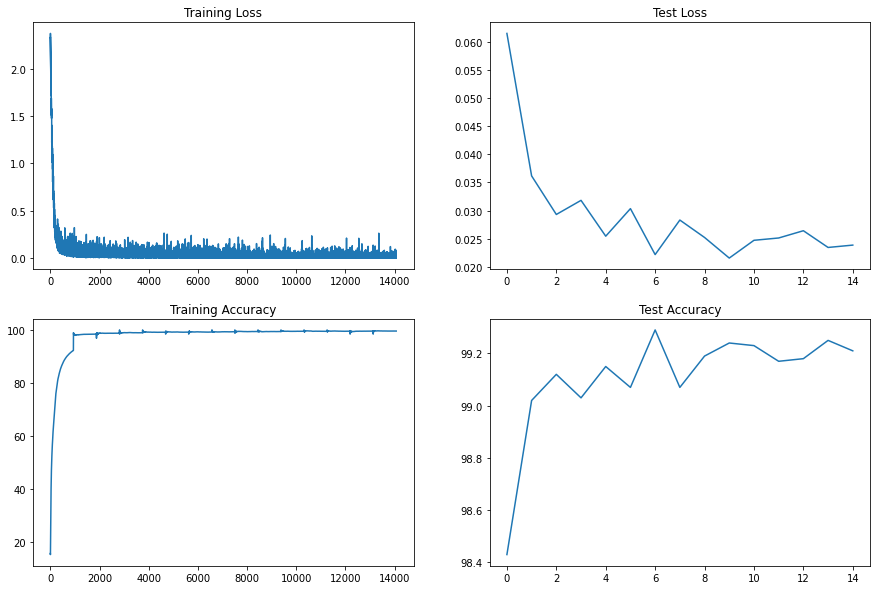

In [37]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")